In [ ]:

!pip install soundfile matplotlib

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt



Saving uma8_raw_recording_30-4-v36wav.wav to uma8_raw_recording_30-4-v36wav.wav


In [ ]:
!pip install pyroomacoustics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 60.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.3-cp311-cp311-linux_x86_64.whl size=46837527 sha256=9c87d232f6b2bfa9214ee24d9c8e0f7f9832950484eb584fa3c93b0ddfd76fae
  Stored in directory: /root/.cache/pip/wheels/63/45/21/e7df2e64ca3b125fd4d6da69c8a4ee46d0ad6acc1f3de6832f
Successfully built pyroomacoustics


In [ ]:
import soundfile as sf
import numpy as np

from google.colab import files
uploaded = files.upload()

audio, fs = sf.read('uma8_raw_audio3.wav')
print(audio.shape)  # Should be (samples, 8)


Saving uma8_raw_audio3.wav to uma8_raw_audio3.wav
(3023237, 8)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
from google.colab import files

# ─── Upload WAV File ────────────────────────────────────────────────
uploaded = files.upload()
input_wav = list(uploaded.keys())[0]




Saving uma8_rawrecording_beamforming.wav to uma8_rawrecording_beamforming (5).wav


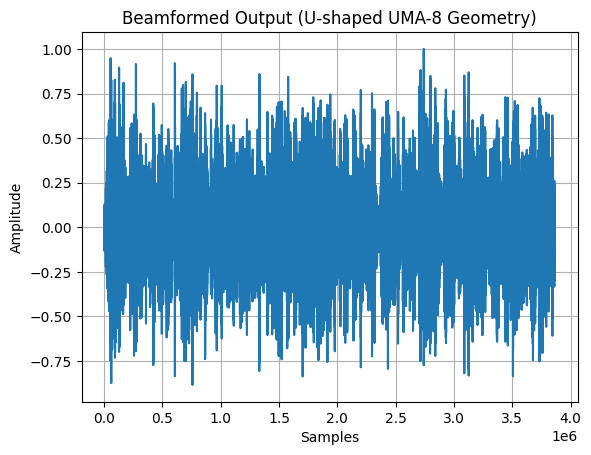

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ─── Beamforming Parameters ──────────────────────────────────────────
sound_speed = 343  # m/s
angle_deg = 0      # steering angle
angle_rad = np.deg2rad(angle_deg)
output_wav = "beamformed_output_test0.wav"

# ─── UMA-8 Microphone Geometry (U-shape) ─────────────────────────────
mic_positions = np.array([
    [-0.0725,  0.0],
    [-0.0525,  0.03],
    [-0.0325,  0.05],
    [-0.0125,  0.06],
    [ 0.0125,  0.06],
    [ 0.0325,  0.05],
    [ 0.0525,  0.03],
    [ 0.0725,  0.0],
])  # in meters

# ─── Load Multi-channel WAV ──────────────────────────────────────────
fs, data = wavfile.read(input_wav)
data = data.astype(np.float32)

if data.ndim != 2 or data.shape[1] != 8:
    raise ValueError("Expected 8-channel WAV input")

num_mics = data.shape[1]
num_samples = data.shape[0]

# ─── Compute Delay for Each Mic ──────────────────────────────────────
steering_vector = np.array([np.cos(angle_rad), np.sin(angle_rad)])  # unit vector
delays_sec = (mic_positions @ steering_vector) / sound_speed
delays_samples = (delays_sec * fs)
min_delay = np.min(delays_samples)
relative_delays = delays_samples - min_delay  # shift so all delays ≥ 0
relative_delays_int = np.round(relative_delays).astype(int)

# ─── Align and Sum ───────────────────────────────────────────────────
max_delay = np.max(relative_delays_int)
aligned_length = num_samples - max_delay
aligned = np.zeros((aligned_length, num_mics))

for i in range(num_mics):
    d = relative_delays_int[i]
    aligned[:, i] = data[d:d + aligned_length, i]

beamformed = np.mean(aligned, axis=1)

# ─── Normalize and Save ──────────────────────────────────────────────
beamformed /= np.max(np.abs(beamformed))
beamformed_int16 = (beamformed * 32767).astype(np.int16)
wavfile.write(output_wav, fs, beamformed_int16)

# ─── Plot and Download ───────────────────────────────────────────────
plt.plot(beamformed)
plt.title("Beamformed Output (U-shaped UMA-8 Geometry)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

files.download(output_wav)



In [ ]:
import numpy as np
print("Per-channel variances:", np.var(data, axis=0))


Per-channel variances: [149248.28   74008.84   37484.742  80556.07   46441.895  48417.21
 214915.83       0.   ]


Sample rate (Hz): 44100
Data shape: (3866624, 8)
Data type: int16
Duration (s): 87.67854875283447
Number of channels: 8
Per-channel variances: [150186.4693431   74459.21659181  37688.11448721  81080.6148269
  46755.72441369  48754.44387271 216564.93236457      0.        ]


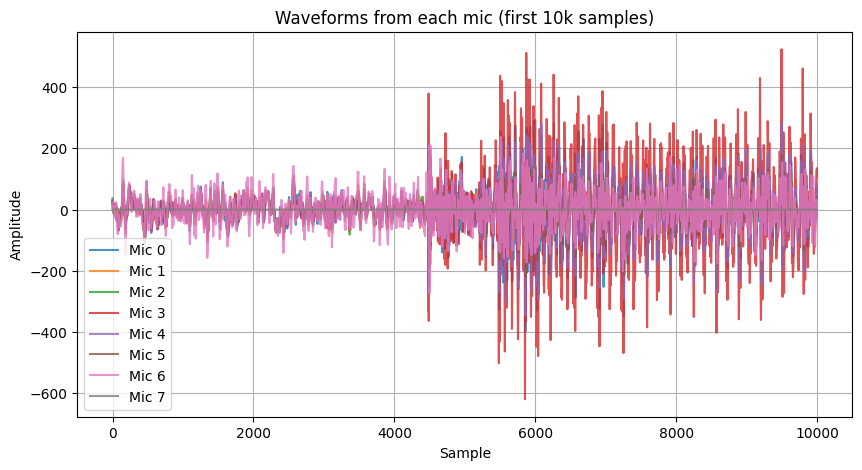

In [ ]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Load your file
file_path = "uma8_rawrecording_beamforming.wav"  # change if needed
fs, data = wavfile.read(file_path)

print("Sample rate (Hz):", fs)
print("Data shape:", data.shape)
print("Data type:", data.dtype)
print("Duration (s):", data.shape[0] / fs)
print("Number of channels:", data.shape[1] if data.ndim > 1 else 1)

# Variance per channel
if data.ndim == 2:
    variances = np.var(data, axis=0)
    print("Per-channel variances:", variances)

    # Plot a snippet from each mic
    plt.figure(figsize=(10, 5))
    for i in range(data.shape[1]):
        plt.plot(data[:10000, i], label=f'Mic {i}', alpha=0.8)
    plt.legend()
    plt.title("Waveforms from each mic (first 10k samples)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
else:
    print("WARNING: File is mono — beamforming not possible.")
